### Galáxias barradas 

Este notebook possui cálculos para melhor caracterizar galáxias barradas. Os cálculos aqui apresentados são de: força da barra, momento do buckling, velocidade circular, fração de gás e taxa de formação estelar. Algumas funções importadas estão escritas em bar_funcs.py

Andressa Wille, 04/04/2023

Aqui estamos usando:

    - Uma simulação com 75% de gás relaxado (se transformando em estrelas) e 20% de bojo
    - Uma simulação sem gás, com 20% de bojo

In [1]:
import matplotlib.pyplot as plt
import h5py
from numpy import *
import numpy as np
from scipy import stats
from scipy.signal import savgol_filter
from bar_funcs import *

In [2]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 15

In [3]:
#caminhos
path_nogas = 'bojo20_200/'
path_rel = 'gas75_rel_200/'
paths = [path_nogas, path_rel]

In [4]:
n_snapshots = 281

In [ ]:
#arrays para força da barra
time_20 = np.empty(n_snapshots)
A2_20 = np.empty(n_snapshots)

time_75r = np.empty(n_snapshots)
A2_75r = np.empty(n_snapshots)

In [ ]:
#arrays para assimetria
S_20 = np.empty(n_snapshots)
S_75r = np.empty(n_snapshots)

In [ ]:
#arrays para fração de gás
gas_frac_20 = np.empty(n_snapshots)
gas_frac_75_r = np.empty(n_snapshots)

In [ ]:
#arrays para velocidade circular
v_c_disk_75r = r_disk_75r = np.empty(n_snapshots)
v_c_halo_75r = r_halo_75r = np.empty(n_snapshots)
v_c_gas_75r = r_gas_75r = np.empty(n_snapshots)
v_c_star_75r = r_star_75r = np.empty(n_snapshots)
v_c_bulge_75r = r_bulge_75r = np.empty(n_snapshots)

v_c_disk_20 = r_disk_20 = np.empty(n_snapshots)
v_c_halo_20 = r_halo_20 = np.empty(n_snapshots)
v_c_bulge_20 = r_bulge_20 = np.empty(n_snapshots)

In [ ]:
#força da barra
for p, path in enumerate(paths):

    for j in range (1, n_snapshots): #alterei o passo inicial para 1 por causa da galáxia com gás
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 1:
            time_75r[j] = round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
            
        #ler info estrelas (se tiver) e corrigir posição
        if p == 1:
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            m_star = np.array(f_star['Masses'])
            
            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)

        #calcular força da barra
        if p == 0:
            A2_20[j] = bar_strength(m=m_disk, x=x_new_disk, y=y_new_disk, Rmax=15.0, Nbins=30, 
                                    n_snapshots=n_snapshots)          
        if p == 1:
            m75r = np.concatenate((m_star,m_disk))
            x75r = np.concatenate((x_new_star,x_new_disk))
            y75r = np.concatenate((y_new_star,y_new_disk))
            A2_75r[j] = bar_strength(m=m75r, x=x75r, y=y75r, Rmax=5.0, Nbins=30, n_snapshots=n_snapshots)

In [ ]:
plt.figure(figsize=[6,6])
plt.plot(time_75r, A2_75r, color='peru', lw=3)
plt.plot(time_20, A2_20, color='skyblue', lw=3)
plt.xlabel('t', fontsize=15)
plt.ylabel('A_2', fontsize=15)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.tight_layout()
#plt.savefig('a2.png')

In [ ]:
plt.figure(figsize=[6,6])
plt.plot(time_75r, A2_75r, color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')
plt.plot(time_20, A2_20, color='skyblue', lw=3, label='no gas, $20\%$ bulge')
plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$A_2$', fontsize=15)
plt.legend(loc='lower right', frameon=False, fontsize=14)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.tight_layout()
#plt.savefig('a2.png')

In [ ]:
#curvas suavizadas

A2_smooth = savgol_filter(A2_20, window_length=9, polyorder=3)
A2_75_smooth = savgol_filter(A2_75r, window_length=9, polyorder=3)

plt.figure(figsize=[6,6])
plt.plot(time_20, A2_smooth, color='skyblue', lw=3, label='no gas, $20\%$ bulge')
plt.plot(time_75r, A2_75_smooth, color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')
plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$A_2$', fontsize=15)
plt.legend(loc='lower right', frameon=False, fontsize=14)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.tight_layout()
#plt.savefig('a2_suavizado.png')

In [ ]:
#assimetria e buckling
for p, path in enumerate(paths):

    for j in range (1, n_snapshots):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        #ler info disco, corrigir posição e selecionar partículas acima e abaixo de z=0
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
       
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        
        up = np.argwhere(z_new_disk > 0).flatten()
        down = np.argwhere(z_new_disk < 0).flatten()

        x_up = x_new_disk[up]
        y_up = y_new_disk[up]
        m_up = m_disk[up]

        x_down = x_new_disk[down]
        y_down = y_new_disk[down]
        m_down = m_disk[down]
            
        #ler info estrelas, se houver, corrigir posição e selecionar partículas acima e abaixo de z=0
        if p == 1:
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            m_star = np.array(f_star['Masses'])
            
            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
            
            up_star = np.argwhere(z_new_star > 0).flatten()
            down_star = np.argwhere(z_new_star < 0).flatten()

            x_up_star = x_new_star[up_star]
            y_up_star = y_new_star[up_star]
            m_up_star = m_star[up_star]

            x_down_star = x_new_star[down_star]
            y_down_star = y_new_star[down_star]
            m_down_star = m_star[down_star]      
        
        #calcular assimetria
        if p == 0:
            S_20[j] = S(m_up, x_up, y_up, m_down, x_down, y_down, Rmax=15.0, Nbins=30,
                        n_snapshots=n_snapshots) 
        if p == 1:
            m_up75r = np.concatenate((m_up_star,m_up))
            x_up75r = np.concatenate((x_up_star,x_up))
            y_up75r = np.concatenate((y_up_star,y_up))
            
            m_down75r = np.concatenate((m_down_star,m_down))
            x_down75r = np.concatenate((x_down_star,x_down))
            y_down75r = np.concatenate((y_down_star,y_down))
            
            S_75r[j] = S(m_up75r, x_up75r, y_up75r, m_down75r, x_down75r, y_down75r, Rmax=5.0, Nbins=30,
                        n_snapshots=n_snapshots) 

In [ ]:
#momento do buckling
for p, path in enumerate(paths):
    if p == 0:
        time_b_20 = time_buckling(S_20, time_20)
        print(time_b_20)
    if p == 1:
        time_b_75r = time_buckling(S_75r, time_75r)
        print(time_b_75r)

In [ ]:
plt.figure(figsize=[6,6])
plt.plot(time_20, S_20, color='skyblue', lw=3, label='no gas, $20\%$ bulge')
plt.plot(time_75r, S_75r, color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')

#plt.vlines(time_b_20, -0.1, 0.3, 'grey')
#plt.annotate(f'buckling \nem {time_b_20} Gyr', xy=(1, 0.25), fontsize=12, color='darkgrey')

plt.xlabel('$t$ (Gyr)', fontsize=15)
plt.ylabel('$S$', fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.ylim(0.0, 0.3)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.tight_layout()
#plt.savefig('S.png')

In [ ]:
#curvas suavizado

S_smooth = savgol_filter(S_20, window_length=9, polyorder=3)
S_75_smooth = savgol_filter(S_75r, window_length=9, polyorder=3)

plt.figure(figsize=[6,6])
plt.plot(time_20, S_smooth, color='skyblue', lw=3, label='no gas, $20\%$ bulge')
plt.plot(time_75r, S_75_smooth, color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')

plt.xlabel('$t$ (Gyr)', fontsize=15)
plt.ylabel('$S$', fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.ylim(0.0, 0.3)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.tight_layout()
#plt.savefig('S_suavizado.png')

In [7]:
#sigma vz em 8 Gyr
for p, path in enumerate(paths):
    snapshot = path + f'snapshot_160.hdf5'

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    #ler info disco, corrigir posição
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    vx_disk = np.array(f_disk['Velocities'][:,0])
    vy_disk = np.array(f_disk['Velocities'][:,1])
    vz_disk = np.array(f_disk['Velocities'][:,2])
    m_disk = np.array(f_disk['Masses'])
       
    x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
    vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

    #raios e sigmas vz
    if p==0:
        r_b, sigma_vz_b = sigma_vz_r(x=x_new_disk, y=y_new_disk, vz=vz_new_disk, Rmax=30.0, Nbins=60)
    if p==1:
        f_star = f['PartType4']

        x_star = np.array(f_star['Coordinates'][:,0])
        y_star = np.array(f_star['Coordinates'][:,1])
        z_star = np.array(f_star['Coordinates'][:,2])
        vx_star = np.array(f_star['Velocities'][:,0])
        vy_star = np.array(f_star['Velocities'][:,1])
        vz_star = np.array(f_star['Velocities'][:,2])
        m_star = np.array(f_star['Masses'])

        x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
        vx_new_star, vy_new_star, vz_new_star = shift_com(m_star, vx_star, vy_star, vz_star)
        
        x = np.concatenate((x_new_star,x_new_disk))
        y = np.concatenate((y_new_star,y_new_disk))
        vz = np.concatenate((vz_new_star,vz_new_disk))
        
        r_nb, sigma_vz_nb = sigma_vz_r(x=x, y=y, vz=vz, Rmax=30.0, Nbins=60)

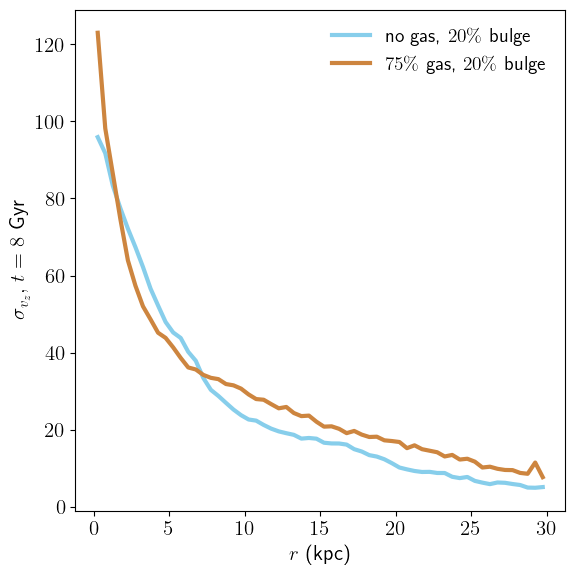

In [8]:
plt.figure(figsize=[6,6])
plt.plot(r_b, sigma_vz_b, color='skyblue', lw=3, label='no gas, $20\%$ bulge')
plt.plot(r_nb, sigma_vz_nb, color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')
plt.xlabel('$r$ (kpc)', fontsize=15)
plt.ylabel('$\sigma_{v_z}, \, t=8$ Gyr', fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig('sigma_vz_8gyr.png')

In [ ]:
sigma_vz_nogas = np.empty(n_snapshots)
sigma_vz_gas = np.empty(n_snapshots)

In [ ]:
#fração de gás
for p, path in enumerate(paths):
    if p == 1: #galáxias que tem gás
        for j in range (0, n_snapshots):
            
            index = str(j).zfill(3)
            snapshot = path + f'snapshot_{index}.hdf5'

            #ler snapshot
            f = h5py.File(snapshot, 'r')

            f_gas = f['PartType0']
            m_gas = sum(np.array(f_gas['Masses']))

            f_disk = f['PartType2']
            m_disk = sum(np.array(f_disk['Masses']))

            f_bulge = f['PartType3']
            m_bulge = sum(np.array(f_bulge['Masses']))
            
            if j == 0:
                m_star = 0
                
            else:
                f_star = f['PartType4']
                m_star = sum(np.array(f_star['Masses']))

            #ler info tempo
            if p == 1:
                time_75r[j] = round(f['Header'].attrs['Time'], 2)

            #calcular fração de gás
            if p == 1:
                gas_frac_75_r[j] = m_gas/(m_gas+m_disk+m_bulge+m_star)

In [ ]:
plt.figure(figsize=[6,6])
plt.plot(time_75r, gas_frac_75_r, color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')
plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
plt.ylabel('$\mathrm{gas \, fraction}$', fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.tight_layout()
#plt.savefig('gas_frac.png')

In [ ]:
#star formation rate
for p, path in enumerate(paths):
    if p == 1: #galáxias que tem gás
        t, sfr = np.loadtxt(path+'sfr.txt', usecols=(0,2), unpack=True)
        
        cond = np.argwhere(t>=0.1).flatten()

        plt.figure(figsize=[6,6])
        plt.plot(t[cond], sfr[cond],  color='peru', lw=3, label='$75\%$ gas, $20\%$ bulge')
        plt.xlabel('$t \, \mathrm{(Gyr)}$', fontsize=15)
        plt.ylabel('$\mathrm{SFR \, ({M}_\odot/yr)}$', fontsize=15)
        plt.legend(loc='upper right', frameon=False, fontsize=14)
        plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
        plt.tight_layout()
        #plt.savefig('sfr_rel.png')

In [ ]:
print(t)

In [ ]:
t14 = np.where(t == 1.419991e+01)
taxa = float(sfr[t14])
print(taxa)

In [ ]:
#velocidade circular
for p, path in enumerate(paths):
    snapshot = path + f'snapshot_050.hdf5' #alterei o passo inicial para 1 por causa da galáxia com gás

    #ler snapshot
    f = h5py.File(snapshot, 'r')
    
    time = round(f['Header'].attrs['Time'], 2)
    print(time)
    
    #ler info disco
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    m_disk = np.array(f_disk['Masses'])
    
    #ler info halo
    f_halo = f['PartType1']

    x_halo = np.array(f_halo['Coordinates'][:,0])
    y_halo = np.array(f_halo['Coordinates'][:,1])
    z_halo = np.array(f_halo['Coordinates'][:,2])
    m_halo = np.array(f_halo['Masses'])
    
    #corrigir posição
    x_new_disk, y_new_disk, z_new_disk = shift_com(m_disk, x_disk, y_disk, z_disk)
    x_new_halo, y_new_halo, z_new_halo = shift_com(m_halo, x_halo, y_halo, z_halo)
    
    #ler info bojo
    f_bulge = f['PartType3']

    x_bulge = np.array(f_bulge['Coordinates'][:,0])
    y_bulge = np.array(f_bulge['Coordinates'][:,1])
    z_bulge = np.array(f_bulge['Coordinates'][:,2])
    m_bulge = np.array(f_bulge['Masses'])
    
    #corrigir posição
    x_new_bulge, y_new_bulge, z_new_bulge = shift_com(m_bulge, x_bulge, y_bulge, z_bulge)

    #se a galáxia também tem gás e estrelas:
    if p == 1:

        #ler info gas
        f_gas = f['PartType0']

        x_gas = np.array(f_gas['Coordinates'][:,0])
        y_gas = np.array(f_gas['Coordinates'][:,1])
        z_gas = np.array(f_gas['Coordinates'][:,2])
        m_gas = np.array(f_gas['Masses'])
        
        x_new_gas, y_new_gas, z_new_gas = shift_com(m_gas, x_gas, y_gas, z_gas)
        
        #ler info estrelas se o snapshot não for 0
        f_star = f['PartType4']

        x_star = np.array(f_star['Coordinates'][:,0])
        y_star = np.array(f_star['Coordinates'][:,1])
        z_star = np.array(f_star['Coordinates'][:,2])
        m_star = np.array(f_star['Masses'])
        
        #corrigir posição
        x_new_star, y_new_star, z_new_star = shift_com(m_star, x_star, y_star, z_star)
        

    #calcular velocidade circular
    G = 43007.1
    if p == 0:
        v_c_disk_20, r_disk_20, M_r_disk_20 = v_circ_comp(m=m_disk, x=x_new_disk, y=y_new_disk, 
                                                          z=z_new_disk, Rmax=30.0, Nbins=90)
        v_c_halo_20, r_halo_20, M_r_halo_20 = v_circ_comp(m=m_halo, x=x_new_halo, y=y_new_halo, 
                                                     z=z_new_halo, Rmax=30.0, Nbins=90)
        v_c_bulge_20, r_bulge_20, M_r_bulge_20 = v_circ_comp(m=m_bulge, x=x_new_bulge, y=y_new_bulge, 
                                                     z=z_new_bulge, Rmax=30.0, Nbins=90)
        
        M_r_tot_20 = (M_r_disk_20 + M_r_halo_20+M_r_bulge_20)
        v_c_20 = (np.sqrt(G*M_r_tot_20/r_disk_20))
        
    if p == 1:
        v_c_disk_75r, r_disk_75r, M_r_disk_75r = v_circ_comp(m=m_disk, x=x_new_disk, y=y_new_disk, 
                                                          z=z_new_disk, Rmax=30.0, Nbins=90)
        v_c_halo_75r, r_halo_75r, M_r_halo_75r = v_circ_comp(m=m_halo, x=x_new_halo, y=y_new_halo, 
                                                     z=z_new_halo, Rmax=30.0, Nbins=90)
        v_c_bulge_75r, r_bulge_75r, M_r_bulge_75r = v_circ_comp(m=m_bulge, x=x_new_bulge, y=y_new_bulge, 
                                                     z=z_new_bulge, Rmax=30.0, Nbins=90)
        v_c_gas_75r, r_gas_75r, M_r_gas_75r = v_circ_comp(m=m_gas, x=x_new_gas, y=y_new_gas, 
                                                     z=z_new_gas, Rmax=30.0, Nbins=90)
        v_c_star_75r, r_star_75r, M_r_star_75r = v_circ_comp(m=m_star, x=x_new_star, y=y_new_star,
                                                     z=z_new_star, Rmax=30.0, Nbins=90)
        
        #M_r_tot_75r = (M_r_disk_75r + M_r_halo_75r + M_r_bulge_75r + M_r_gas_75r)
        M_r_tot_75r = (M_r_disk_75r + M_r_halo_75r + M_r_bulge_75r + M_r_gas_75r + M_r_star_75r)
        v_c_75r = (np.sqrt(G*M_r_tot_75r/r_disk_75r))

In [ ]:
r = [r_disk_20, r_disk_75r]
v_c_disk = [v_c_disk_20, v_c_disk_75r]
v_c_halo = [v_c_halo_20, v_c_halo_75r]
v_c_bulge = [v_c_bulge_20, v_c_bulge_75r]
v_c_gas = [0, v_c_gas_75r]
v_c_star = [0, v_c_star_75r]
v_c = [v_c_20, v_c_75r]

In [ ]:
for i in range (0, 2):
    if i == 0:
        plt.figure(figsize=[6,6])
        plt.plot(r[i], v_c_disk[i], color='aqua', lw=3, label='disk')
        plt.plot(r[i], v_c_halo[i], color='yellow', lw=3, label='halo')
        plt.plot(r[i], v_c_bulge[i], color='darkgreen', lw=3, label='bulge')
        plt.plot(r[i], v_c[i], color='red', lw=3, label='total')
        plt.xlabel('$R$ (kpc)', fontsize=15)
        plt.ylabel('$v_c$ (km/s)', fontsize=15)
        plt.legend(frameon=False)
        plt.ylim(10, 240)
    
        text ='no gas, $20\%$ bulge'
        
        plt.text(10, 200, text, fontsize=15)

    if i == 1:
        plt.figure(figsize=[6,6])
        plt.plot(r[i], v_c_disk[i], color='aqua', lw=3, label='disk')
        plt.plot(r[i], v_c_star[i], color='blue', lw=3, label='stars')
        plt.plot(r[i], v_c_halo[i], color='yellow', lw=3, label='halo')
        plt.plot(r[i], v_c_bulge[i], color='darkgreen', lw=3, label='bulge')
        plt.plot(r[i], v_c_gas[i], color='magenta', lw=3, label='gas')
        plt.plot(r[i], v_c[i], color='red', lw=3, label='total')
        plt.xlabel('$R$ (kpc)', fontsize=15)
        plt.ylabel('$v_c$ (km/s)', fontsize=15)
        plt.legend(frameon=False)
        plt.ylim(10, 240)
    
        text ='$75\%$ gas, $20\%$ bulge'
        
        plt.text(10, 200, text, fontsize=15)

        
        plt.figure(figsize=[6,6])
        plt.plot(r[i], v_c_disk[i]+v_c_star[i], color='aqua', lw=3, label='disk + stars')
        plt.plot(r[i], v_c_halo[i], color='yellow', lw=3, label='halo')
        plt.plot(r[i], v_c_bulge[i], color='darkgreen', lw=3, label='bulge')
        plt.plot(r[i], v_c_gas[i], color='magenta', lw=3, label='gas')
        plt.plot(r[i], v_c[i], color='red', lw=3, label='total')
        plt.xlabel('$R$ (kpc)', fontsize=15)
        plt.ylabel('$v_c$ (km/s)', fontsize=15)
        plt.legend(frameon=False)
        plt.ylim(10, 240)
    
        text ='$75\%$ gas, $20\%$ bulge'
        
        plt.text(10, 200, text, fontsize=15)

    
    plt.tight_layout()
    #plt.savefig(f'vc_{i}.png')

In [ ]:
#teste de visualização
# for j in range (0, n_snapshots, 20): 
#     index = str(j).zfill(3)
snapshot = 'bojo20_200/' + 'snapshot_000.hdf5' #f'snapshot_{index}.hdf5'

#ler snapshot
f = h5py.File(snapshot, 'r')

#ler info disco
f_disk = f['PartType2']

x_disk = np.array(f_disk['Coordinates'][:,0])
y_disk = np.array(f_disk['Coordinates'][:,1])
z_disk = np.array(f_disk['Coordinates'][:,2])
vx_disk = np.array(f_disk['Velocities'][:,0])
vy_disk = np.array(f_disk['Velocities'][:,1])
vz_disk = np.array(f_disk['Velocities'][:,2])
m_disk = np.array(f_disk['Masses'])
Ndisk = len(np.array(f_disk['ParticleIDs']))

t = round(f['Header'].attrs['Time'], 2)
        
#corrigir posição - centro de massa
x_new_disk, y_new_disk, z_new_disk = shift_com(m_disk, x_disk, y_disk, z_disk)
vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)
            
#corrigir posição - momento angular - disk
theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)



In [ ]:
#mapa de alturas z e velocidades vz - média
for j in range (0, n_snapshots, 20): 
    index = str(j).zfill(3)
    #snapshot = path_nogas + f'snapshot_{index}.hdf5' 
    #snapshot = path_rel + f'snapshot_{index}.hdf5'
    snapshot = 'sat01-10/' + f'snapshot_{index}.hdf5'
    #substituir o path - galáxia com ou sem gás

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    #ler info disco
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    vx_disk = np.array(f_disk['Velocities'][:,0])
    vy_disk = np.array(f_disk['Velocities'][:,1])
    vz_disk = np.array(f_disk['Velocities'][:,2])
    m_disk = np.array(f_disk['Masses'])
    Ndisk = len(np.array(f_disk['ParticleIDs']))

    t = round(f['Header'].attrs['Time'], 2)
        
    #corrigir posição - centro de massa
    x_new_disk, y_new_disk, z_new_disk = shift_com(m_disk, x_disk, y_disk, z_disk)
    vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)
            
    #corrigir posição - momento angular - disk
    theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
    x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
    x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
    
    #mapas de posição e velocidade
    Nbins = 50

    Rmax =  35.0 #kpc
    xmin = ymin = -Rmax
    xmax = ymax = Rmax

    results, xb, yb, binnum = stats.binned_statistic_2d(x_new_disk, y_new_disk, z_new_disk, 
                                    statistic='mean', bins=Nbins, range=[[xmin,xmax],[ymin,ymax]])

    results1, xb, yb, binnum = stats.binned_statistic_2d(x_new_disk, y_new_disk, vz_new_disk, 
                                    statistic='mean', bins=Nbins, range=[[xmin,xmax],[ymin,ymax]])

    extent = [xb[0], xb[-1], yb[0], yb[-1]]

    Q = results
    Q1 = results1
    
    #posições
    
    fig = plt.figure()
    ax1  = plt.subplot(111)

    fig.set_size_inches(4.5,3.5)

    im = plt.imshow(Q.T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest', 
                    vmin=-2, vmax=2)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    ax1.set_aspect('equal')

    time = t
    ax1.set_title(f'Time = {time} Gyr')
    cb = fig.add_axes()
    cb = fig.colorbar(im, cax=cb, orientation="vertical")
    cb.set_label(r'$z~({\rm kpc})$')
    ax1.set_xlabel(r'$x~({\rm kpc})$')
    ax1.set_ylabel(r'$y~({\rm kpc})$')

    plt.tight_layout()
    plt.savefig(f'z-01-10_{index}.png')
    
    
    #velocidades
    
    fig = plt.figure()
    ax1  = plt.subplot(111)

    fig.set_size_inches(4.5,3.5)

    im = plt.imshow(Q1.T, extent=extent, origin='lower', cmap="PuOr", interpolation='nearest', 
                    vmin=-30, vmax=30)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    ax1.set_aspect('equal')

    time = t
    ax1.set_title(f'Time = {time} Gyr')
    cb = fig.add_axes()
    cb = fig.colorbar(im, cax=cb, orientation="vertical")
    cb.set_label(r'$v_z~({\rm kpc})$')
    ax1.set_xlabel(r'$x~({\rm kpc})$')
    ax1.set_ylabel(r'$y~({\rm kpc})$')

    plt.tight_layout()
    plt.savefig(f'vz-01-10_{index}.png')

In [ ]:
#mapa de alturas z - desvio
for j in range (0, n_snapshots, 20): 
    index = str(j).zfill(3)
    #snapshot = path_nogas + f'snapshot_{index}.hdf5' 
    snapshot = path_rel + f'snapshot_{index}.hdf5' 
    #substituir o path - galáxia com ou sem gás

    #ler snapshot
    f = h5py.File(snapshot, 'r')

    #ler info disco
    f_disk = f['PartType2']

    x_disk = np.array(f_disk['Coordinates'][:,0])
    y_disk = np.array(f_disk['Coordinates'][:,1])
    z_disk = np.array(f_disk['Coordinates'][:,2])
    vx_disk = np.array(f_disk['Velocities'][:,0])
    vy_disk = np.array(f_disk['Velocities'][:,1])
    vz_disk = np.array(f_disk['Velocities'][:,2])
    m_disk = np.array(f_disk['Masses'])
    Ndisk = len(np.array(f_disk['ParticleIDs']))

    t = round(f['Header'].attrs['Time'], 2)
        
    #corrigir posição - centro de massa
    x_new_disk, y_new_disk, z_new_disk = shift_com(m_disk, x_disk, y_disk, z_disk)
    vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)
            
    #corrigir posição - momento angular - disk
    theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
    x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
    x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
    

    #mapas de posição e velocidade
    Nbins = 50

    Rmax =  35.0 #kpc
    xmin = ymin = -Rmax
    xmax = ymax = Rmax

    results, xb, yb, binnum = stats.binned_statistic_2d(x_new_disk, y_new_disk, z_new_disk, 
                                    statistic='std', bins=Nbins, range=[[xmin,xmax],[ymin,ymax]])

    extent = [xb[0], xb[-1], yb[0], yb[-1]]

    Q = results
    
    #posições
    
    fig = plt.figure()
    ax1  = plt.subplot(111)

    fig.set_size_inches(4.5,3.5)

    im = plt.imshow(Q.T, extent=extent, origin='lower', cmap="BrBG", interpolation='nearest', 
                    vmin=-2, vmax=2)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    ax1.set_aspect('equal')

    time = t
    ax1.set_title(f'Time = {time} Gyr')
    cb = fig.add_axes()
    cb = fig.colorbar(im, cax=cb, orientation="vertical")
    cb.set_label(r'$\sigma_z~({\rm kpc})$')
    ax1.set_xlabel(r'$x~({\rm kpc})$')
    ax1.set_ylabel(r'$y~({\rm kpc})$')

    plt.tight_layout()
    #plt.savefig(f'stdz_nb_{index}.png')